In [1]:
%load_ext autoreload
%autoreload 2
from plotting_report import *
import pickle
from pathlib import Path
import os
import scanpy as sc
import cellink as cl
import pandas as pd
from cellink.tl._burden_testing import *
import warnings
warnings.filterwarnings("ignore")

/data/nasif12/home_if12/l_mai/.conda/envs/mm_scgenetics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
out_path = Path("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/")
eigenvec = pd.read_csv("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/input_data/pcdir/wgs.dose.filtered.R2_0.8.filtered.pruned.eigenvec", sep=' ', header=None)
df_results = pd.read_csv(out_path/ "association/all_results_newest.csv")
df_final = pd.read_csv(out_path/ "association/all_results_FDR_corrected_newest.csv")
df_summary = pd.read_csv(out_path/ "association/all_results_summary_newest.csv")
df_burdens = pd.read_parquet(out_path/"burdens/all_burdens_newest.parquet")

## Get interesting genes

In [14]:
df_filtered = (
    df_final.query("significant")
    .groupby("burden_gene")
    .agg(
        Number_of_Appearence=("celltype-annotation", "nunique"),  # Count unique significant cell types
        Chromosomes=("chromosome", lambda x: ",".join(map(str, sorted(x.unique())))),  # Aggregate unique chromosomes
        Cell_Types=("cell_type", lambda x: ",".join(sorted(x.unique()))),  # Aggregate unique cell types
        Burden_Types=("burden_type", lambda x: ",".join(sorted(x.unique()))),  # Aggregate unique burden types
    )
    .sort_values(by="Number_of_Appearence", ascending=False)  # Sort by highest number of significant cell types
)
df_filtered

Number_of_Appearence Chromosomes  \
burden_gene                                         
ENSG00000124614                    37           6   
ENSG00000145425                    33           4   
ENSG00000204632                    25           6   
ENSG00000036448                    19           8   
ENSG00000102898                    16          16   
...                               ...         ...   
ENSG00000142687                     1           1   
ENSG00000101639                     1          18   
ENSG00000101413                     1          20   
ENSG00000177600                     1          11   
ENSG00000172915                     1          13   

                                                        Cell_Types  \
burden_gene                                                          
ENSG00000124614  B IN,B Mem,CD4 ET,CD4 NC,CD8 ET,CD8 NC,CD8 S10...   
ENSG00000145425  B IN,B Mem,CD4 ET,CD4 NC,CD4 SOX4,CD8 ET,CD8 N...   
ENSG00000204632  B Mem,CD4 ET,CD4 NC,CD8 ET,CD8 NC,CD8 S100B,Mo...   
ENSG00000036448    B IN,CD4 ET,CD4 NC,CD8 ET,CD8 NC,CD8 S100B,NK R   
ENSG00000102898            B Mem,CD4 NC,CD8 ET,CD8 NC,CD8 S100B,NK   
...                                                            ...   
ENSG00000142687                                               NK R   
ENSG00000101639                                             CD4 NC   
ENSG00000101413                                                 DC   
ENSG00000177600                                             CD4 NC   
ENSG00000172915                                                 NK   

                                                      Burden_Types  
burden_gene                                                         
ENSG00000124614  CADD_PHRED,DNA_LM_combined,DNA_LM_down,DNA_LM_...  
ENSG00000145425   CADD_PHRED,GENE_TSS_DISTANCE_SAIGE,MAF_beta_1.25  
ENSG00000204632   CADD_PHRED,GENE_TSS_DISTANCE_SAIGE,MAF_beta_1.25  
ENSG00000036448   CADD_PHRED,GENE_TSS_DISTANCE_SAIGE,MAF_beta_1.25  
ENSG00000102898  CADD_PHRED,DNA_LM_down,DNA_LM_up,GENE_TSS_DIST...  
...                                                            ...  
ENSG00000142687                                         CADD_PHRED  
ENSG00000101639                                      MAF_beta_1.25  
ENSG00000101413                                        DNA_LM_down  
ENSG00000177600                            GENE_TSS_DISTANCE_SAIGE  
ENSG00000172915                                          DNA_LM_up  

[520 rows x 4 columns]

In [89]:
genes_oi = ["ENSG00000099365", "ENSG00000160445", "ENSG00000132958", "ENSG00000132953", "ENSG00000226816","ENSG00000198520"]

In [90]:
df_gene_oi = df_filtered[df_filtered.index.isin(genes_oi)]
df_gene_oi

Number_of_Appearence Chromosomes     Cell_Types  \
burden_gene                                                        
ENSG00000226816                     9           7  CD4 NC,CD8 NC   
ENSG00000198520                     5           1  CD4 NC,CD8 NC   
ENSG00000160445                     5           9      CD8 S100B   
ENSG00000099365                     5          16         CD4 NC   
ENSG00000132958                     4          13         CD4 NC   
ENSG00000132953                     4          13      CD8 S100B   

                                                      Burden_Types  
burden_gene                                                         
ENSG00000226816  CADD_PHRED,DNA_LM_combined,DNA_LM_down,DNA_LM_...  
ENSG00000198520  DNA_LM_combined,DNA_LM_down,DNA_LM_up,MAF_beta...  
ENSG00000160445  CADD_PHRED,DNA_LM_combined,DNA_LM_down,DNA_LM_...  
ENSG00000099365  DNA_LM_combined,DNA_LM_down,DNA_LM_up,GENE_TSS...  
ENSG00000132958  DNA_LM_combined,DNA_LM_down,DNA_LM_up,MAF_beta...  
ENSG00000132953  DNA_LM_combined,DNA_LM_down,DNA_LM_up,MAF_beta...

## Plot genes of interest

In [ ]:
save_dir = out_path / "data_plots/pb_expression/gene_oi"

Getting PB CD8 S100B
[2025-01-31 19:05:15,373] INFO:cellink._core.donordata: Keeping 980/981 donors
[2025-01-31 19:05:15,374] INFO:cellink._core.donordata: Dropping 1/981 donors from genetic data
[2025-01-31 19:05:15,375] INFO:cellink._core.donordata: Dropping 0/980 donors from single-cell data


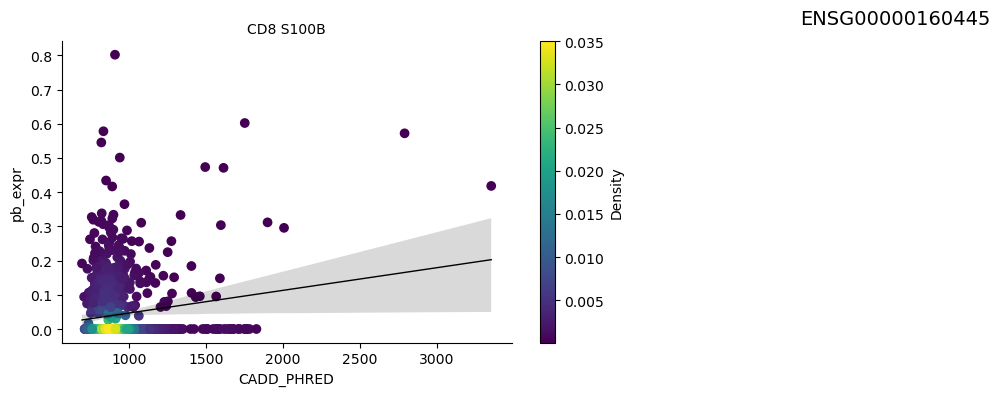

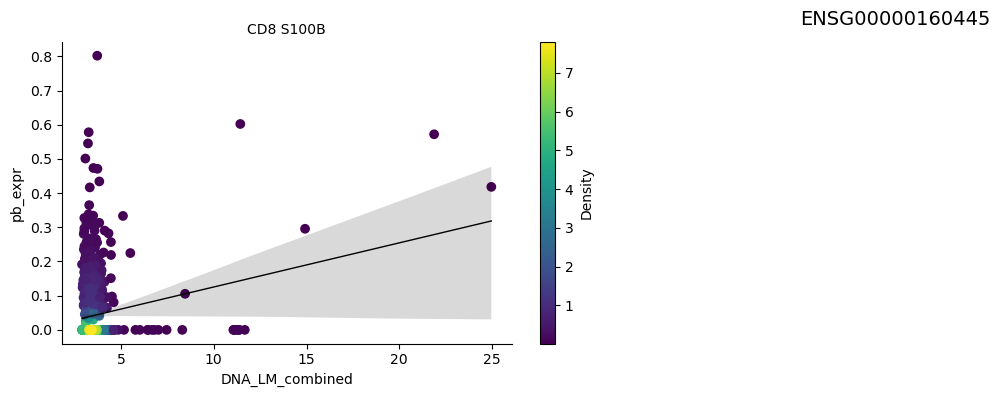

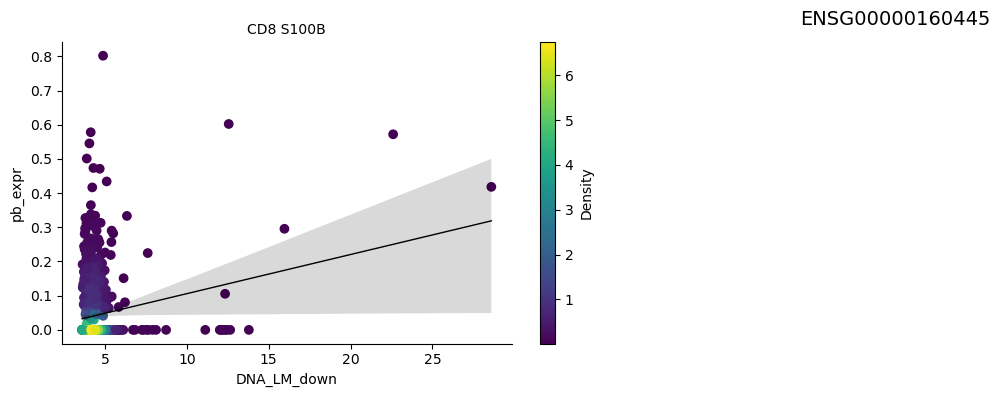

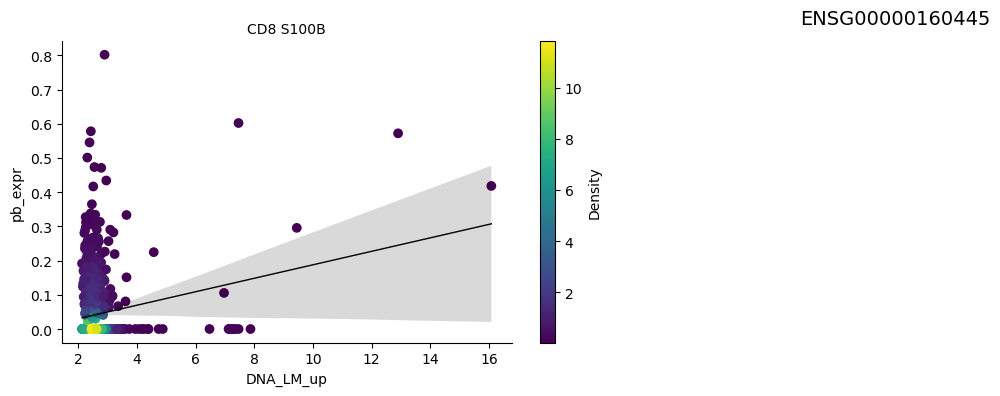

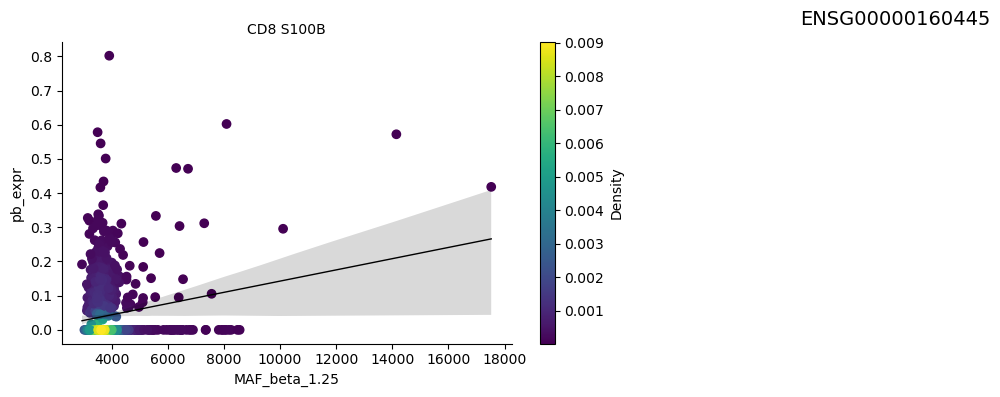

In [96]:
chrom = "9"
gene_oi = "ENSG00000160445"
data = pd.read_pickle(out_path/f"annotations/chr{chrom}_data.pkl")
data.gdata.varm["annotations_0"] = data.gdata.varm["annotations_0"].rename(columns={'DNA_LM_mixed': 'DNA_LM_combined'})
df_burdens_for_chrom = df_burdens[df_burdens["Chromosome"] == chrom]
get_pb_plots(data,
             df_burdens_for_chrom,
             eigenvec,
             chrom,
             cell_types=df_gene_oi.loc[gene_oi]["Cell_Types"].split(","),
             burden_types=df_gene_oi.loc[gene_oi]["Burden_Types"].split(","),
             gene_list=[gene_oi],
             save_dir="")

Getting PB CD4 NC
[2025-01-31 19:11:32,755] INFO:cellink._core.donordata: Keeping 981/981 donors
[2025-01-31 19:11:32,755] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2025-01-31 19:11:32,755] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data


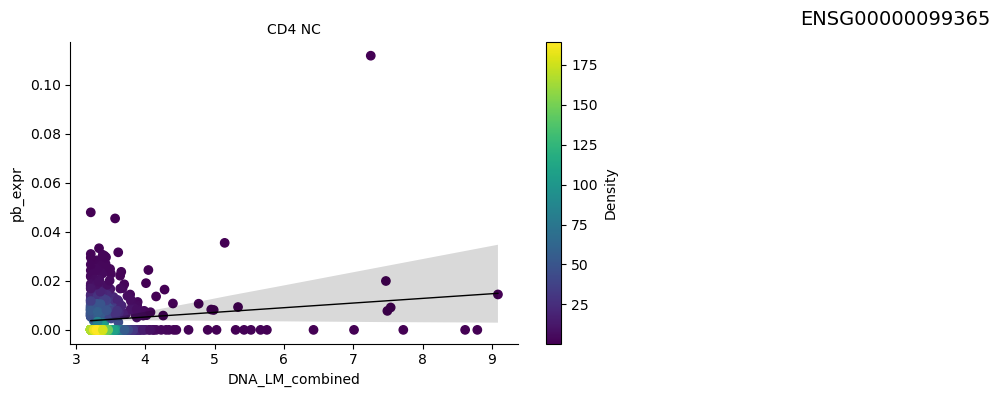

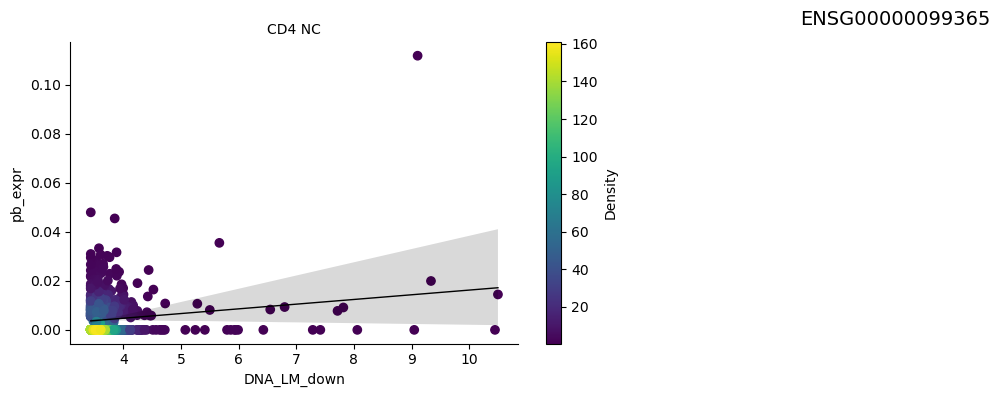

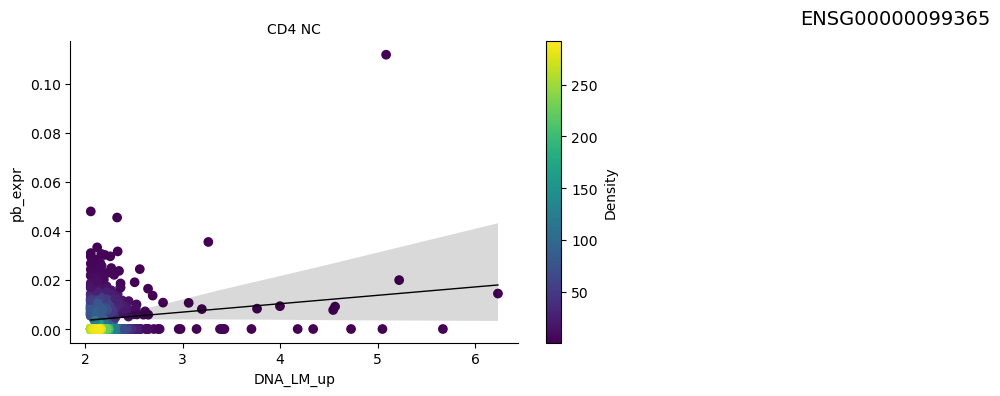

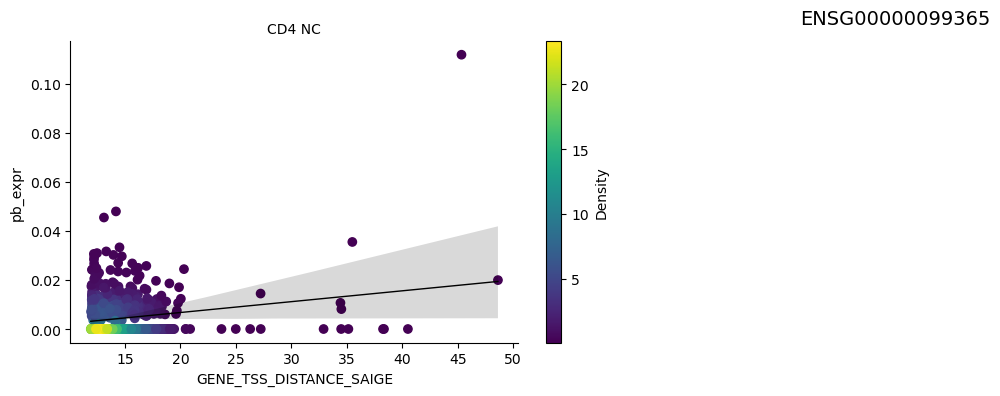

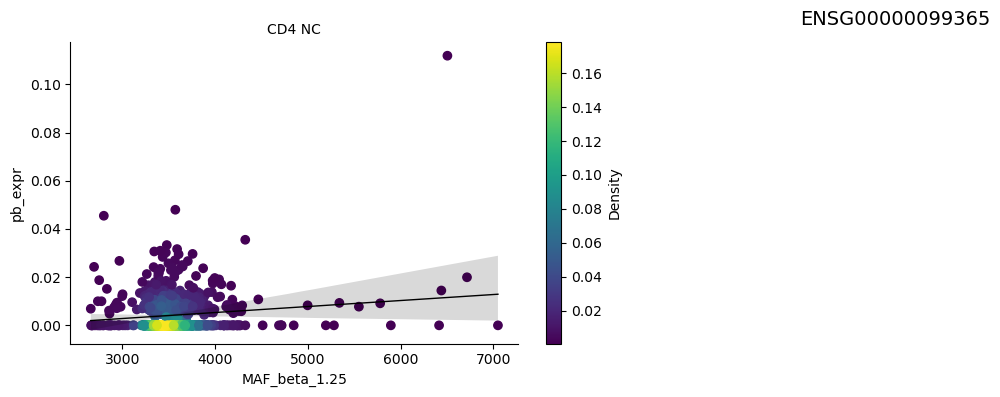

In [97]:
chrom = "16"
gene_oi = "ENSG00000099365"
data = pd.read_pickle(out_path/f"annotations/chr{chrom}_data.pkl")
data.gdata.varm["annotations_0"] = data.gdata.varm["annotations_0"].rename(columns={'DNA_LM_mixed': 'DNA_LM_combined'})
df_burdens_for_chrom = df_burdens[df_burdens["Chromosome"] == chrom]
get_pb_plots(data,
             df_burdens_for_chrom,
             eigenvec,
             chrom,
             cell_types=df_gene_oi.loc[gene_oi]["Cell_Types"].split(","),
             burden_types=df_gene_oi.loc[gene_oi]["Burden_Types"].split(","),
             gene_list=[gene_oi],
             save_dir="")

Getting PB CD4 NC
[2025-01-31 19:11:43,168] INFO:cellink._core.donordata: Keeping 981/981 donors
[2025-01-31 19:11:43,169] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2025-01-31 19:11:43,169] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data


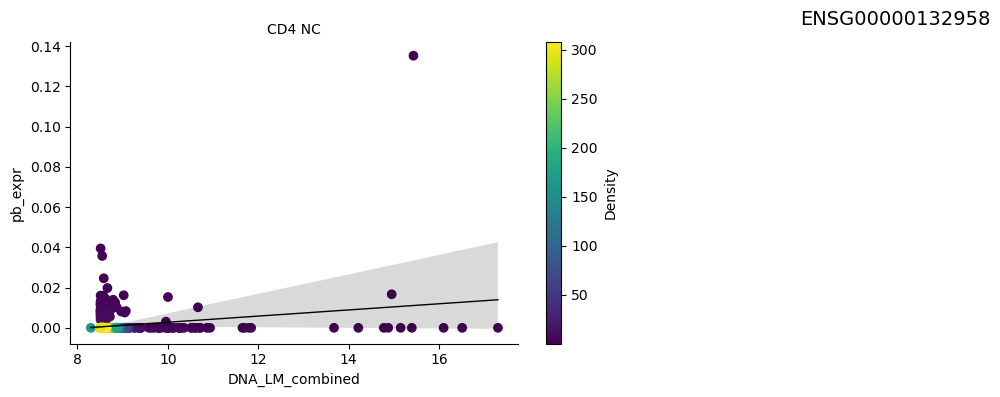

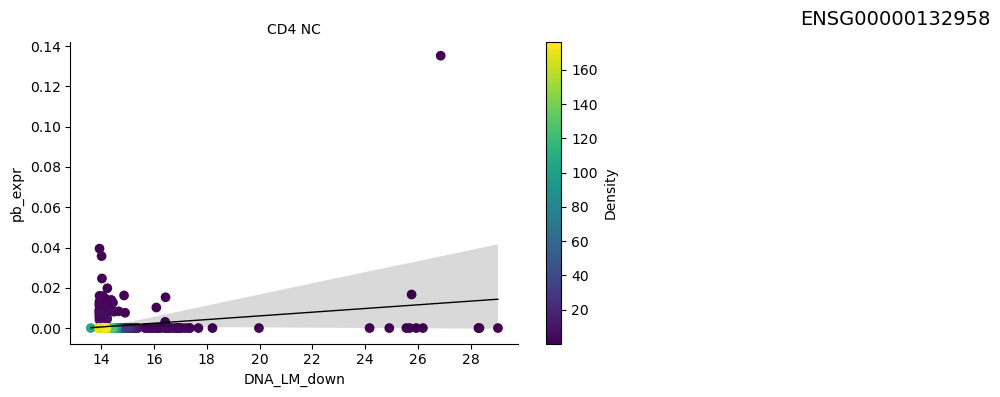

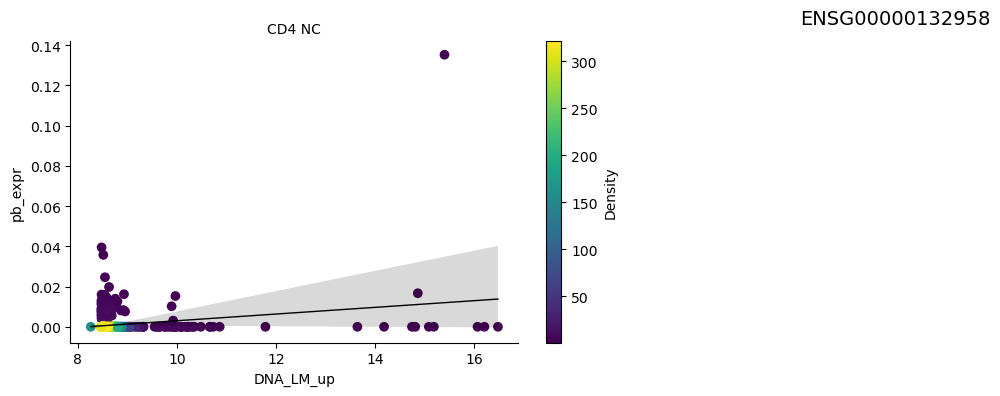

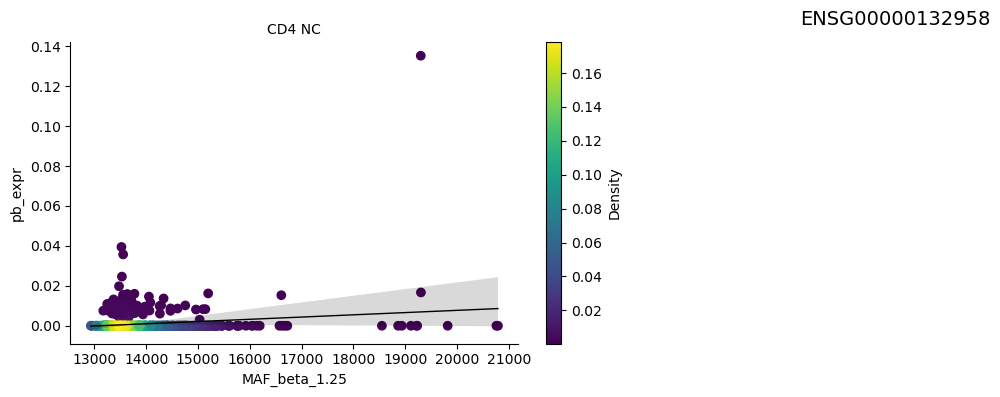

In [98]:
chrom = "13"
gene_oi = "ENSG00000132958"
data = pd.read_pickle(out_path/f"annotations/chr{chrom}_data.pkl")
data.gdata.varm["annotations_0"] = data.gdata.varm["annotations_0"].rename(columns={'DNA_LM_mixed': 'DNA_LM_combined'})
df_burdens_for_chrom = df_burdens[df_burdens["Chromosome"] == chrom]
get_pb_plots(data,
             df_burdens_for_chrom,
             eigenvec,
             chrom,
             cell_types=df_gene_oi.loc[gene_oi]["Cell_Types"].split(","),
             burden_types=df_gene_oi.loc[gene_oi]["Burden_Types"].split(","),
             gene_list=[gene_oi],
             save_dir="")

Getting PB CD8 S100B
[2025-01-31 19:12:55,915] INFO:cellink._core.donordata: Keeping 980/981 donors
[2025-01-31 19:12:55,915] INFO:cellink._core.donordata: Dropping 1/981 donors from genetic data
[2025-01-31 19:12:55,916] INFO:cellink._core.donordata: Dropping 0/980 donors from single-cell data


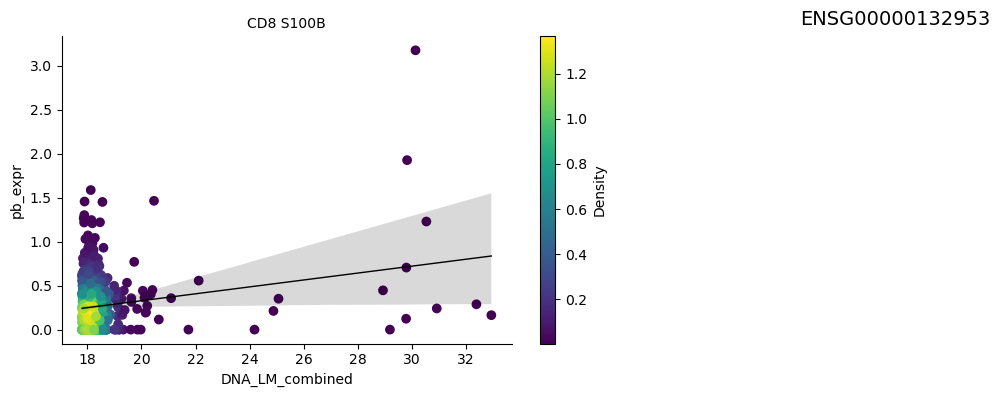

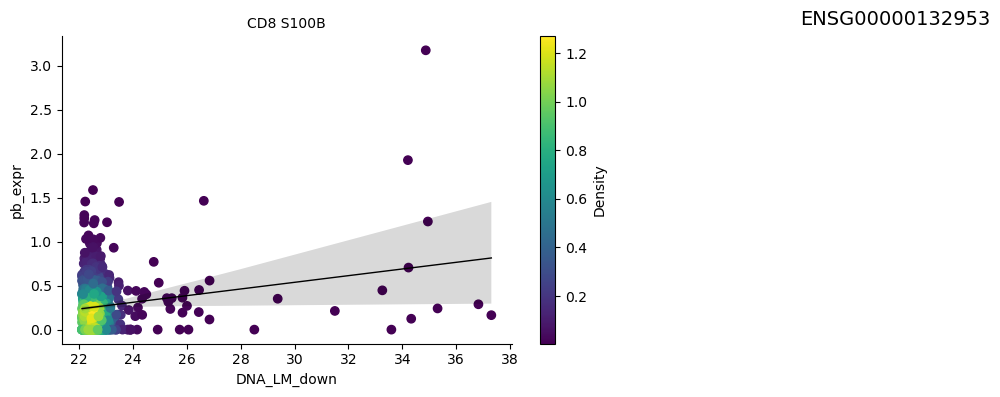

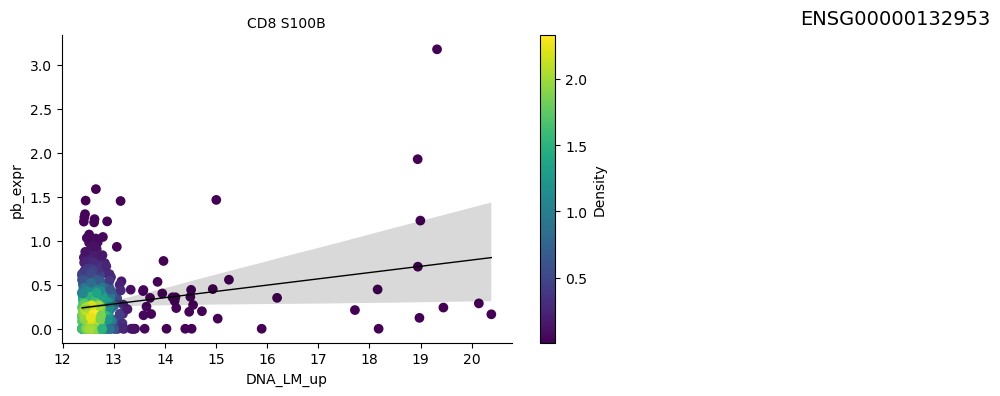

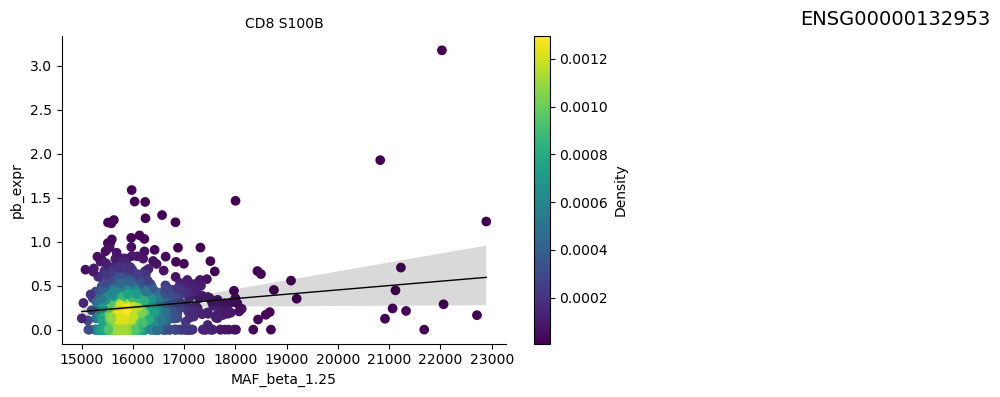

In [101]:
chrom = "13"
gene_oi = "ENSG00000132953"
data = pd.read_pickle(out_path/f"annotations/chr{chrom}_data.pkl")
data.gdata.varm["annotations_0"] = data.gdata.varm["annotations_0"].rename(columns={'DNA_LM_mixed': 'DNA_LM_combined'})
df_burdens_for_chrom = df_burdens[df_burdens["Chromosome"] == chrom]
get_pb_plots(data,
             df_burdens_for_chrom,
             eigenvec,
             chrom,
             cell_types=df_gene_oi.loc[gene_oi]["Cell_Types"].split(","),
             burden_types=df_gene_oi.loc[gene_oi]["Burden_Types"].split(","),
             gene_list=[gene_oi],
             save_dir="")

Getting PB CD4 NC
[2025-01-31 19:12:39,298] INFO:cellink._core.donordata: Keeping 981/981 donors
[2025-01-31 19:12:39,299] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2025-01-31 19:12:39,299] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
Getting PB CD8 NC
[2025-01-31 19:12:47,659] INFO:cellink._core.donordata: Keeping 981/981 donors
[2025-01-31 19:12:47,660] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2025-01-31 19:12:47,660] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data


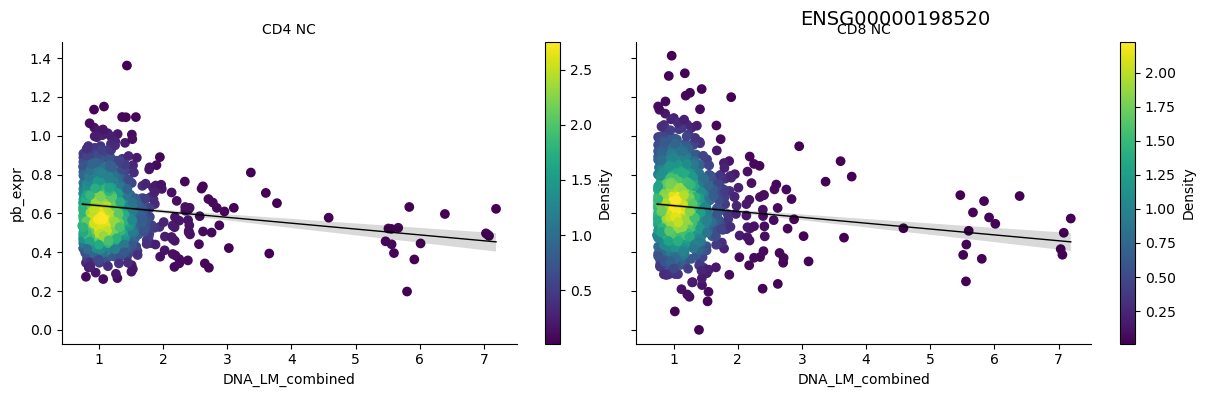

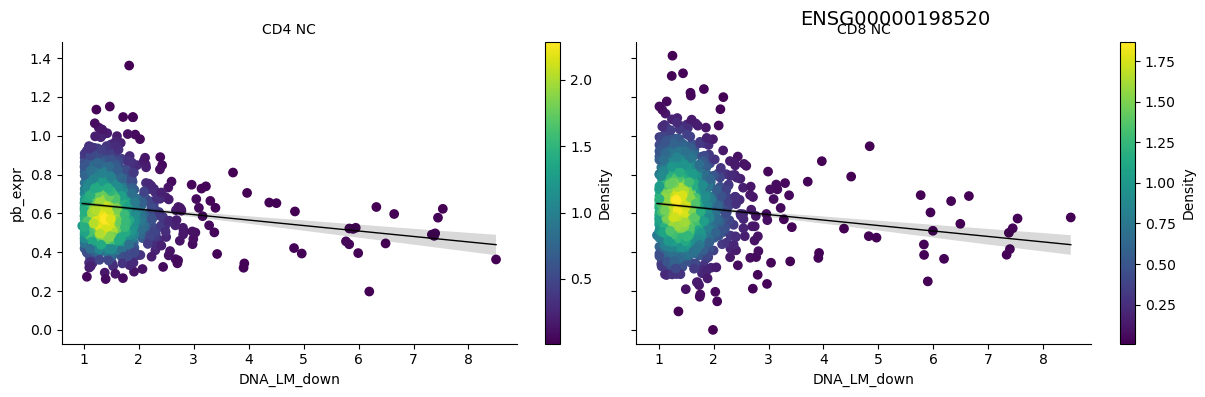

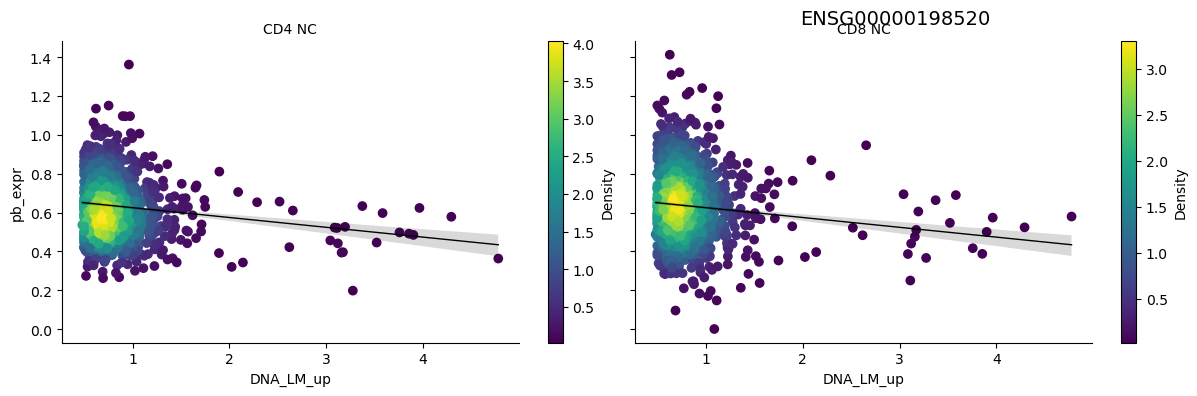

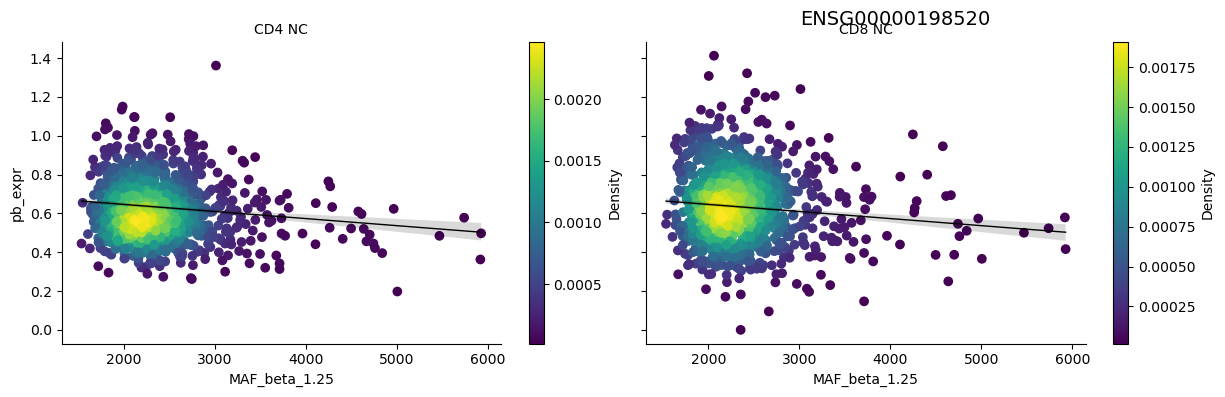

In [100]:
chrom = "1"
gene_oi = "ENSG00000198520"
data = pd.read_pickle(out_path/f"annotations/chr{chrom}_data.pkl")
data.gdata.varm["annotations_0"] = data.gdata.varm["annotations_0"].rename(columns={'DNA_LM_mixed': 'DNA_LM_combined'})
df_burdens_for_chrom = df_burdens[df_burdens["Chromosome"] == chrom]
get_pb_plots(data,
             df_burdens_for_chrom,
             eigenvec,
             chrom,
             cell_types=df_gene_oi.loc[gene_oi]["Cell_Types"].split(","),
             burden_types=df_gene_oi.loc[gene_oi]["Burden_Types"].split(","),
             gene_list=[gene_oi],
             save_dir="")

Getting PB CD4 NC
[2025-01-31 19:15:06,943] INFO:cellink._core.donordata: Keeping 981/981 donors
[2025-01-31 19:15:06,944] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2025-01-31 19:15:06,944] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
Getting PB CD8 NC
[2025-01-31 19:15:10,483] INFO:cellink._core.donordata: Keeping 981/981 donors
[2025-01-31 19:15:10,484] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2025-01-31 19:15:10,484] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data


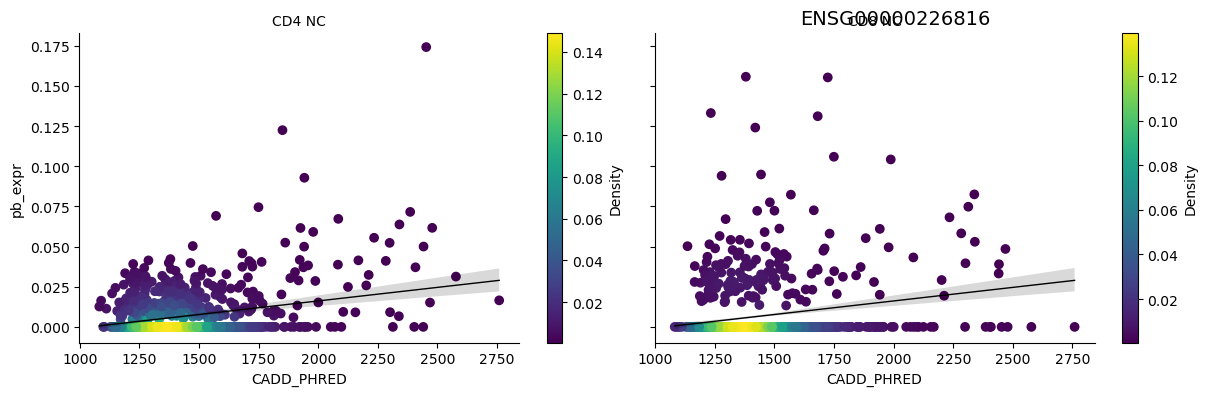

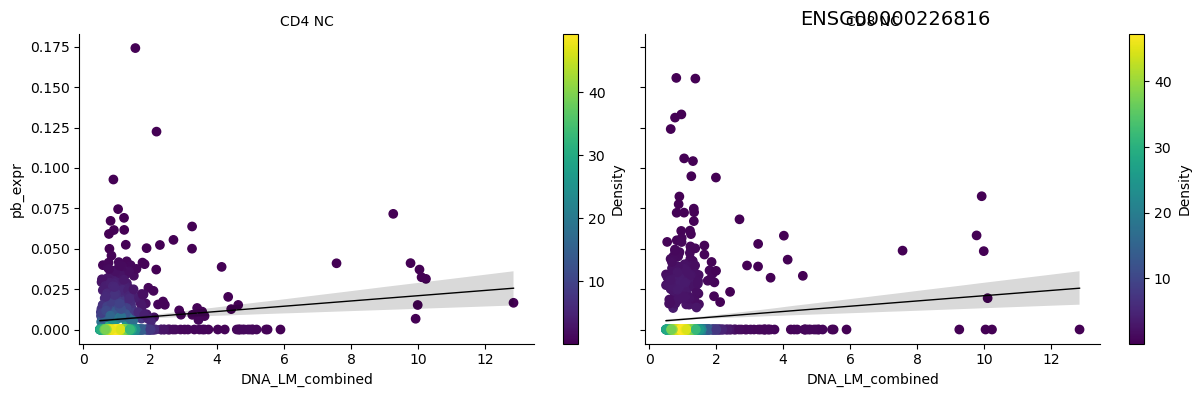

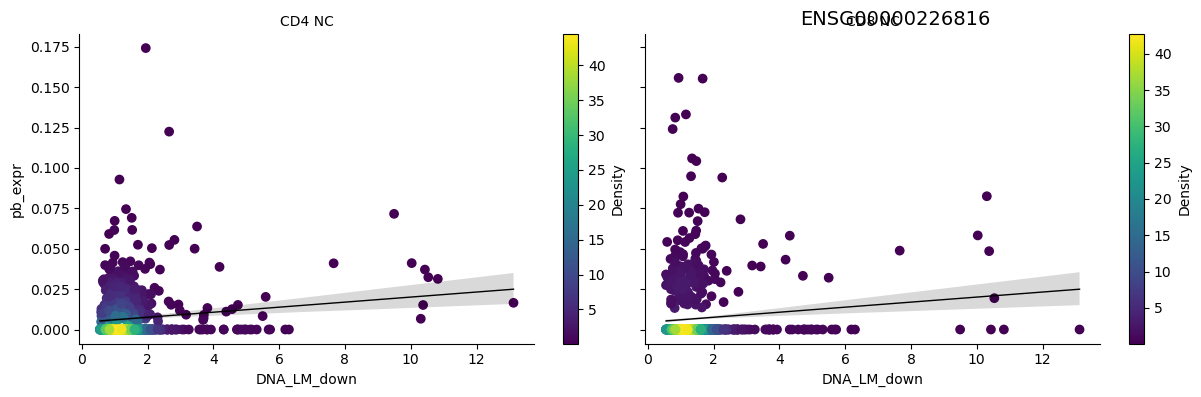

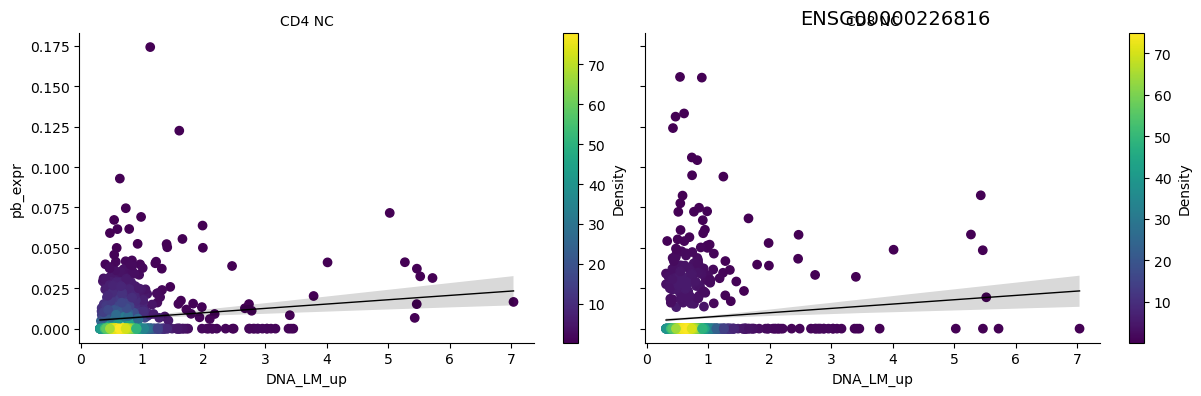

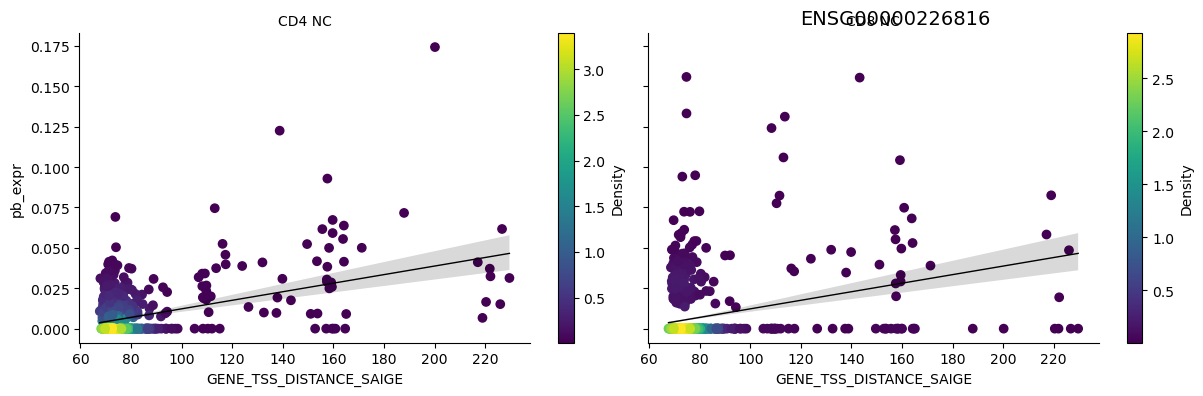

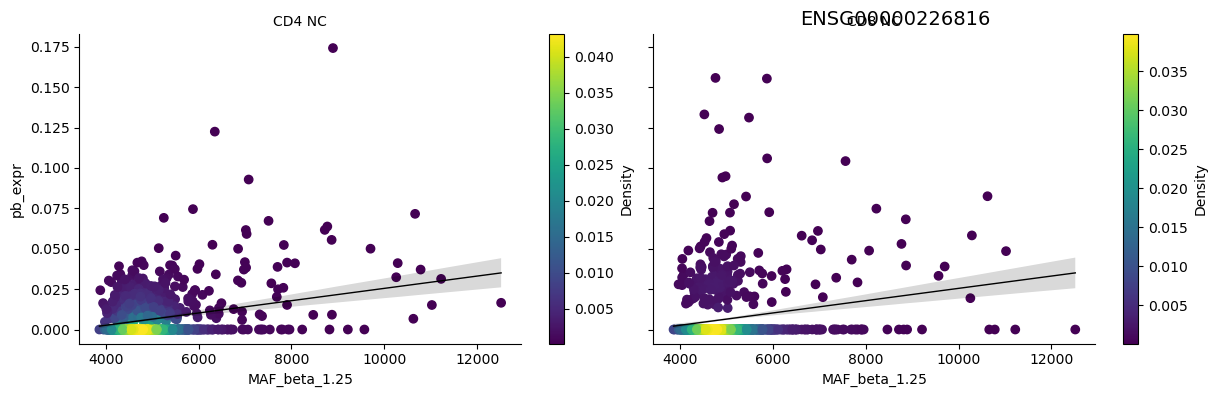

In [105]:
chrom = "7"
gene_oi = "ENSG00000226816"
data = pd.read_pickle(out_path/f"annotations/chr{chrom}_data.pkl")
data.gdata.varm["annotations_0"] = data.gdata.varm["annotations_0"].rename(columns={'DNA_LM_mixed': 'DNA_LM_combined'})
df_burdens_for_chrom = df_burdens[df_burdens["Chromosome"] == chrom]
get_pb_plots(data,
             df_burdens_for_chrom,
             eigenvec,
             chrom,
             cell_types=df_gene_oi.loc[gene_oi]["Cell_Types"].split(","),
             burden_types=df_gene_oi.loc[gene_oi]["Burden_Types"].split(","),
             gene_list=[gene_oi],
             save_dir="")